# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>Naive Bayes</h1>

<h1>1. Naive Bayes with BOW </h1>

<h2>1.0 Import necessary libraries</h2>

In [40]:
# Here I have used following references and modify as accordingly 
# https://www.kaggle.com/nikhilparmar9/naive-bayes-donorschoose-dataset
# https://www.kaggle.com/nikhilparmar9/naive-bayes-donorschoose-dataset/data
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://github.com/pskadasi/DecisionTrees_DonorsChoose/blob/master/Copy_of_8_DonorsChoose_DT_(1).ipynb

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter

## 1.1 Loading Data

In [4]:
project_df = pd.read_csv('preprocessed_data.csv')
project_df.head()


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [5]:
print(project_df.shape)
print(project_df['project_is_approved'].value_counts())

(109248, 9)
1    92706
0    16542
Name: project_is_approved, dtype: int64


In [6]:
y = project_df['project_is_approved'].values
X = project_df.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)


<h2>1.3 Make Data Model Ready: encoding eassay</h2>

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer1 = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer1.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer1.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer1.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 5000) (73196,)
(36052, 5000) (36052,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

vectorizer2 = CountVectorizer()
vectorizer2.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer2.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer2.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer2.get_feature_names())
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 51) (73196,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


vectorizer3 = CountVectorizer()
vectorizer3.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer3.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer3.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer3.get_feature_names())
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 5) (73196,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


vectorizer4 = CountVectorizer()
vectorizer4.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer4.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer4.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer4.get_feature_names())
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 4) (73196,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [12]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


vectorizer5 = CountVectorizer()
vectorizer5.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleancategories_ohe = vectorizer5.transform(X_train['clean_categories'].values)
X_test_cleancategories_ohe = vectorizer5.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_cleancategories_ohe.shape, y_train.shape)
print(X_test_cleancategories_ohe.shape, y_test.shape)
print(vectorizer5.get_feature_names())
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 9) (73196,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


vectorizer6 = CountVectorizer()
vectorizer6.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleansubcategories_ohe = vectorizer6.transform(X_train['clean_subcategories'].values)
X_test_cleansubcategories_ohe = vectorizer6.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_cleansubcategories_ohe.shape, y_train.shape)
print(X_test_cleansubcategories_ohe.shape, y_test.shape)
print(vectorizer6.get_feature_names())
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 30) (73196,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [14]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [15]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [16]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_cleancategories_ohe, X_train_cleansubcategories_ohe, X_train_price_norm, X_train_previously_posted_projects_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_cleancategories_ohe, X_test_cleansubcategories_ohe, X_test_price_norm, X_test_previously_posted_projects_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 5101) (73196,)
(36052, 5101) (36052,)


<h2>1.5 write a function which is doing batch wise prediction to get auc score</h2>

In [17]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

<h2>1.5 Building a Model</h2>

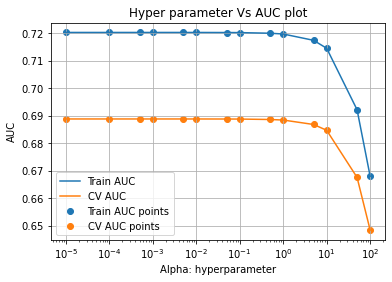

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.164352,0.025081,0.040466,0.017756,1e-05,{'alpha': 1e-05},0.682586,0.687952,0.695913,0.688817,0.005475,1,0.720508,0.721191,0.719232,0.720310,0.000812
2,0.139608,0.005778,0.025096,0.003238,0.0001,{'alpha': 0.0001},0.682585,0.687951,0.695913,0.688817,0.005475,2,0.720508,0.721191,0.719232,0.720310,0.000812
1,0.139640,0.001419,0.027260,0.000471,0.0005,{'alpha': 0.0005},0.682585,0.687951,0.695913,0.688816,0.005475,3,0.720508,0.721191,0.719232,0.720310,0.000812
4,0.139970,0.002633,0.027263,0.000473,0.001,{'alpha': 0.001},0.682585,0.687951,0.695912,0.688816,0.005475,4,0.720508,0.721190,0.719232,0.720310,0.000812
3,0.144139,0.002249,0.028247,0.001229,0.005,{'alpha': 0.005},0.682584,0.687950,0.695911,0.688815,0.005475,5,0.720505,0.721188,0.719230,0.720308,0.000812
6,0.140957,0.001695,0.028603,0.000932,0.01,{'alpha': 0.01},0.682582,0.687948,0.695909,0.688813,0.005475,6,0.720503,0.721186,0.719227,0.720305,0.000812
5,0.144628,0.005633,0.027604,0.000477,0.05,{'alpha': 0.05},0.682572,0.687931,0.695891,0.688798,0.005472,7,0.720481,0.721162,0.719203,0.720282,0.000812
7,0.152067,0.013539,0.031212,0.001402,0.1,{'alpha': 0.1},0.682557,0.687913,0.695866,0.688779,0.005468,8,0.720452,0.721133,0.719173,0.720253,0.000812
8,0.146894,0.010378,0.027152,0.006895,0.5,{'alpha': 0.5},0.682410,0.687762,0.695695,0.688622,0.005457,9,0.720231,0.720906,0.718938,0.720025,0.000816
9,0.157911,0.008031,0.039894,0.010204,1,{'alpha': 1},0.682235,0.687566,0.695475,0.688426,0.005439,10,0.719956,0.720624,0.718642,0.719740,0.000823


In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

MNB_bow = MultinomialNB(class_prior=[0.5,0.5], fit_prior = True)
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = GridSearchCV(MNB_bow, parameters, cv=3, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_alpha']

plt.semilogx(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results

In [19]:
best_alpha_bow = 1

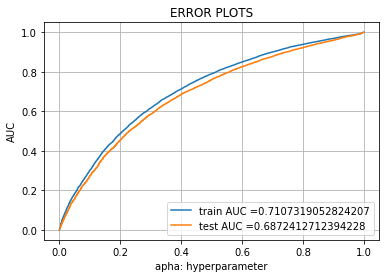

In [20]:
from sklearn.metrics import roc_curve, auc

MNB_bow = MultinomialNB(alpha=best_alpha_bow)
MNB_bow.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(MNB_bow, X_tr)    
y_test_pred = batch_predict(MNB_bow, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("apha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [21]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [22]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
print("Train confusion matrix")
print(cm_train)
print("Test confusion matrix")
print(cm_test)

the maximum value of tpr*(1-fpr) 0.43665285272265286 for threshold 0.832
Train confusion matrix
[[ 7364  3719]
 [21294 40819]]
Test confusion matrix
[[ 3457  2002]
 [10532 20061]]


<AxesSubplot:>

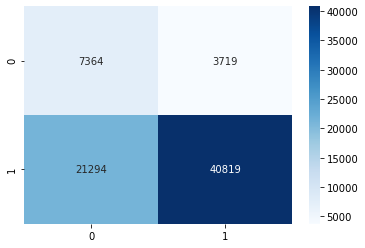

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt 

sns.heatmap(cm_train, annot=True,fmt="d",cmap='Blues')

<AxesSubplot:>

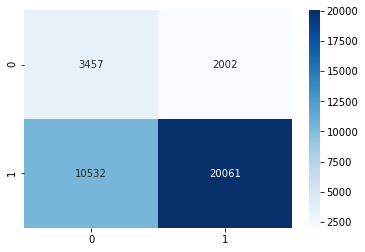

In [24]:
sns.heatmap(cm_test, annot=True,fmt="d",cmap='Blues')

<h2>1.4 top 25 features from feature Set 1 using values of `feature_log_prob_ ` parameter of `MultinomialNB`  and print both positive as well as negative corresponding feature names.</h2>

### (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In [26]:
neg_class_prob_sorted_set1 = MNB_bow.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted_set1 = MNB_bow.feature_log_prob_[1, :].argsort()

In [27]:
from itertools import chain
Stacked_Feature_list = list(chain(vectorizer1.get_feature_names(),vectorizer2.get_feature_names(),vectorizer3.get_feature_names(), vectorizer4.get_feature_names(),vectorizer5.get_feature_names(),vectorizer6.get_feature_names(), X_train_price_norm, X_train_previously_posted_projects_norm ))

In [56]:
print("The words with higest importance in Negative class is")
print(np.take(Stacked_Feature_list, neg_class_prob_sorted_set1[-26:-1]))
print("*"*20)
print("The words with higest importance in Positive class is")
print(np.take(Stacked_Feature_list, pos_class_prob_sorted_set1[-26:-1]))

The words with higest importance in Negative class is
['use' 'day' 'skills' 'reading' 'able' 'materials' 'love' array([1.])
 'come' 'work' 'need' 'we' 'many' 'nannan' array([1.]) 'my students' 'the'
 'help' 'they' 'learn' 'not' 'classroom' 'my' 'learning' 'school']
********************
The words with higest importance in Positive class is
['would' 'class' 'come' 'able' 'day' 'love' array([1.]) 'use' 'reading'
 'work' 'need' 'we' 'nannan' 'many' array([1.]) 'help' 'learn'
 'my students' 'not' 'they' 'the' 'classroom' 'learning' 'my' 'school']


<h1>2.1 Naive Bayes with TFIDF </h1>

<h2>2.2 Make Data Model Ready: encoding eassay</h2>

In [30]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)


vectorizer21 = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer21.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer21.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer21.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 5000) (73196,)
(36052, 5000) (36052,)


<h2>2.3 Make Data Model Ready: encoding numerical, categorical features</h2>

In [31]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer22 = CountVectorizer()
vectorizer22.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_schoolstate_ohe_1 = vectorizer22.transform(X_train['school_state'].values)
X_test_schoolstate_ohe_1 = vectorizer22.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_schoolstate_ohe_1.shape, y_train.shape)
print(X_test_schoolstate_ohe_1.shape, y_test.shape)
print(vectorizer22.get_feature_names())
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 51) (73196,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [32]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer23 = CountVectorizer()
vectorizer23.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacherprefix_ohe_1 = vectorizer23.transform(X_train['teacher_prefix'].values)
X_test_teacherprefix_ohe_1 = vectorizer23.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacherprefix_ohe_1.shape, y_train.shape)
print(X_test_teacherprefix_ohe_1.shape, y_test.shape)
print(vectorizer23.get_feature_names())
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 5) (73196,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [33]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer24 = CountVectorizer()
vectorizer24.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_projectgradecategory_ohe_1 = vectorizer24.transform(X_train['project_grade_category'].values)
X_test_projectgradecategory_ohe_1 = vectorizer24.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_projectgradecategory_ohe_1.shape, y_train.shape)
print(X_test_projectgradecategory_ohe_1.shape, y_test.shape)
print(vectorizer24.get_feature_names())
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 4) (73196,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [34]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer25 = CountVectorizer()
vectorizer25.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleancategories_ohe_1 = vectorizer25.transform(X_train['clean_categories'].values)
X_test_cleancategories_ohe_1 = vectorizer25.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_cleancategories_ohe_1.shape, y_train.shape)
print(X_test_cleancategories_ohe_1.shape, y_test.shape)
print(vectorizer25.get_feature_names())
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 9) (73196,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [35]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

vectorizer26 = CountVectorizer()
vectorizer26.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cleansubcategories_ohe_1 = vectorizer26.transform(X_train['clean_subcategories'].values)
X_test_cleansubcategories_ohe_1 = vectorizer26.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_cleansubcategories_ohe_1.shape, y_train.shape)
print(X_test_cleansubcategories_ohe_1.shape, y_test.shape)
print(vectorizer26.get_feature_names())
print("="*100)

(73196, 8) (73196,)
(36052, 8) (36052,)
After vectorizations
(73196, 30) (73196,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [36]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm_1 = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm_1 = normalizer.transform(X_test['price'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_price_norm_1.shape, y_train.shape)
print(X_test_price_norm_1.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [37]:
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_previously_posted_projects_norm_1 = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previously_posted_projects_norm_1 = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_previously_posted_projects_norm_1.shape, y_train.shape)
print(X_test_previously_posted_projects_norm_1.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [38]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_1 = hstack((X_train_essay_tfidf, X_train_schoolstate_ohe_1, X_train_teacherprefix_ohe_1, X_train_projectgradecategory_ohe_1, X_train_cleancategories_ohe_1, X_train_cleansubcategories_ohe_1, X_train_price_norm_1, X_train_previously_posted_projects_norm_1)).tocsr()
X_te_1 = hstack((X_test_essay_tfidf, X_test_schoolstate_ohe_1, X_test_teacherprefix_ohe_1, X_test_projectgradecategory_ohe_1, X_test_cleancategories_ohe_1, X_test_cleansubcategories_ohe_1, X_test_price_norm_1, X_test_previously_posted_projects_norm_1)).tocsr()

print("Final Data matrix")
print(X_tr_1.shape, y_train.shape)
print(X_te_1.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 5101) (73196,)
(36052, 5101) (36052,)


In [39]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

<h2>2.4 Building a model using GridSearchCV</h2>

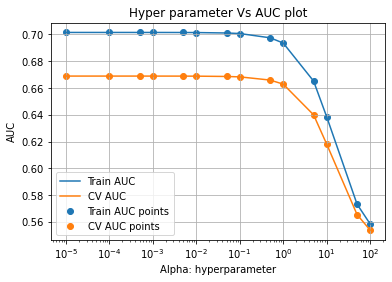

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.178532,0.008011,0.028925,0.002154,1e-05,{'alpha': 1e-05},0.657502,0.674828,0.674343,0.668891,0.008056,1,0.698751,0.704286,0.701416,0.701484,0.002260
2,0.190159,0.004485,0.040559,0.004483,0.0001,{'alpha': 0.0001},0.657501,0.674828,0.674343,0.668891,0.008056,2,0.698751,0.704285,0.701416,0.701484,0.002260
1,0.168330,0.025031,0.040252,0.011580,0.0005,{'alpha': 0.0005},0.657499,0.674826,0.674340,0.668888,0.008056,3,0.698748,0.704281,0.701413,0.701481,0.002260
4,0.156249,0.007892,0.038246,0.011860,0.001,{'alpha': 0.001},0.657496,0.674823,0.674337,0.668885,0.008056,4,0.698744,0.704277,0.701409,0.701476,0.002259
3,0.174534,0.015896,0.033577,0.004485,0.005,{'alpha': 0.005},0.657477,0.674800,0.674312,0.668863,0.008054,5,0.698713,0.704241,0.701377,0.701443,0.002257
6,0.161256,0.027746,0.027274,0.000485,0.01,{'alpha': 0.01},0.657450,0.674772,0.674278,0.668833,0.008052,6,0.698673,0.704196,0.701337,0.701402,0.002255
5,0.176195,0.021870,0.027594,0.000941,0.05,{'alpha': 0.05},0.657237,0.674548,0.674014,0.668600,0.008038,7,0.698362,0.703850,0.701020,0.701077,0.002241
7,0.163230,0.023039,0.035905,0.007769,0.1,{'alpha': 0.1},0.656960,0.674256,0.673681,0.668299,0.008021,8,0.697974,0.703416,0.700626,0.700672,0.002222
8,0.148623,0.006957,0.027607,0.000930,0.5,{'alpha': 0.5},0.654787,0.671918,0.671022,0.665909,0.007873,9,0.694907,0.700071,0.697471,0.697483,0.002108
9,0.140979,0.001246,0.027607,0.000453,1,{'alpha': 1},0.652033,0.668948,0.667676,0.662886,0.007692,10,0.691143,0.696056,0.693566,0.693589,0.002006


In [42]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

MNB_tfidf = MultinomialNB(class_prior=[0.5,0.5], fit_prior = True)
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = GridSearchCV(MNB_tfidf, parameters, cv=3, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr_1, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_alpha']

plt.semilogx(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results

In [43]:
best_alpha_tfidf = 0.01

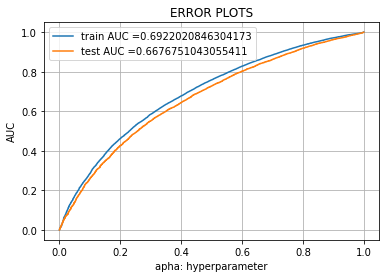

In [44]:
from sklearn.metrics import roc_curve, auc

MNB_tfidf = MultinomialNB(alpha=best_alpha_tfidf)
MNB_tfidf.fit(X_tr_1, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(MNB_tfidf, X_tr_1)    
y_test_pred = batch_predict(MNB_tfidf, X_te_1)

train_fpr_1, train_tpr_1, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr_1, test_tpr_1, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr_1, train_tpr_1, label="train AUC ="+str(auc(train_fpr_1, train_tpr_1)))
plt.plot(test_fpr_1, test_tpr_1, label="test AUC ="+str(auc(test_fpr_1, test_tpr_1)))
plt.legend()
plt.xlabel("apha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [45]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [46]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr_1, train_tpr_1)
cm_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
print("Train confusion matrix")
print(cm_train)
print("Test confusion matrix")
print(cm_test)

the maximum value of tpr*(1-fpr) 0.4132459977800151 for threshold 0.85
Train confusion matrix
[[ 7271  3812]
 [22988 39125]]
Test confusion matrix
[[ 3364  2095]
 [11362 19231]]


<AxesSubplot:>

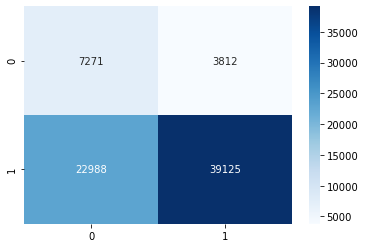

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt 

sns.heatmap(cm_train, annot=True,fmt="d",cmap='Blues')

<AxesSubplot:>

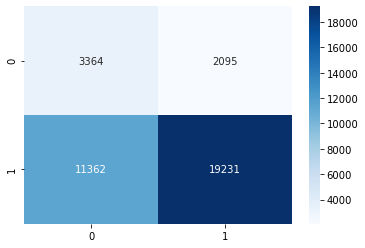

In [48]:
sns.heatmap(cm_test, annot=True,fmt="d",cmap='Blues')

<h2>2.5 top 25 features from feature Set 1 using values of `feature_log_prob_ ` parameter of `MultinomialNB`  and print both positive as well as negative corresponding feature names.</h2>

### (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

In [49]:
neg_class_prob_sorted_set2 = MNB_tfidf.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted_set2 = MNB_tfidf.feature_log_prob_[1, :].argsort()

In [50]:
from itertools import chain
Stacked_Feature_list = list(chain(vectorizer21.get_feature_names(),vectorizer22.get_feature_names(),vectorizer23.get_feature_names(), vectorizer24.get_feature_names(),vectorizer25.get_feature_names(),vectorizer26.get_feature_names(), X_train_price_norm_1, X_train_previously_posted_projects_norm-1 ))

In [55]:
print("The words with higest importance in Negative class is")
print(np.take(Stacked_Feature_list, neg_class_prob_sorted_set2[-26:-1]))
print("*"*20)
print("The words with higest importance in Positive class is")
print(np.take(Stacked_Feature_list, pos_class_prob_sorted_set2[-26:-1]))

The words with higest importance in Negative class is
['ny' 'visualarts' 'health_wellness' 'tx' 'music_arts' 'mr' 'grades_9_12'
 'appliedsciences' 'students' 'appliedlearning' 'health_sports' 'ca'
 'specialneeds' 'specialneeds' 'grades_6_8' 'literature_writing'
 'literacy' 'mathematics' 'grades_3_5' 'ms' 'math_science' 'grades_prek_2'
 'literacy_language' 'mrs' array([1.])]
********************
The words with higest importance in Positive class is
['visualarts' 'tx' 'ny' 'music_arts' 'health_wellness' 'mr'
 'appliedsciences' 'grades_9_12' 'appliedlearning' 'specialneeds'
 'specialneeds' 'students' 'health_sports' 'ca' 'grades_6_8'
 'literature_writing' 'mathematics' 'literacy' 'grades_3_5' 'ms'
 'math_science' 'grades_prek_2' 'literacy_language' 'mrs' array([1.])]


<h2>Summary using Pretty Table</h2>

In [57]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "Vectorizer", "Hyper Parameter Alpha", "AUC"]

table.add_row(["Naive Bayes","BOW", best_alpha_bow, str(auc(test_fpr, test_tpr))])
table.add_row(["Naive Bayes","TFIDF", best_alpha_tfidf, str(auc(test_fpr_1, test_tpr_1))])

print (table)

+-------------+------------+-----------------------+--------------------+
|    Model    | Vectorizer | Hyper Parameter Alpha |        AUC         |
+-------------+------------+-----------------------+--------------------+
| Naive Bayes |    BOW     |           1           | 0.6872412712394228 |
| Naive Bayes |   TFIDF    |          0.01         | 0.6676751043055411 |
+-------------+------------+-----------------------+--------------------+
